In [7]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from pathlib import Path
import sys
sys.path.append('../../')
from utils.metrics import calculate_anomaly_metrics, format_results
from utils.plots import standard_plots

In [8]:
# 1. LOAD DATA
train = pd.read_csv('../data/train.csv')

feature_cols = [
    'sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 'sensor_8', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_17'

]


In [9]:
X_train_all = train[feature_cols].values

model = IsolationForest(
    contamination=0.08,
    random_state=42,
    n_estimators=100
)
model.fit(X_train_all)

,n_estimators,100
,max_samples,'auto'
,contamination,0.08
,max_features,1.0
,bootstrap,False
,n_jobs,None
,random_state,42
,verbose,0
,warm_start,False


In [10]:
# 4. PREDICT
# Then predict on train and test
predictions = model.predict(X_train_all)
train['is_anomaly'] = (predictions == -1).astype(int)
train['anomaly_score'] = -model.decision_function(X_train_all)

In [11]:
# 5. METRICS
metrics = calculate_anomaly_metrics(train)
metrics['method'] = 'Isolation Forest'
metrics['dataset'] = 'FD001'
format_results(metrics)


📊 Isolation Forest - FD001
Cobertura: 100.0% (100/100 unidades)
RUL promedio 1ª detección: 57.6 ciclos
Detección al 81.5% del ciclo
Detecciones tempranas (RUL>50): 13
Falsos positivos (RUL>150): 13.0%
% anomalías totales: 8.0%


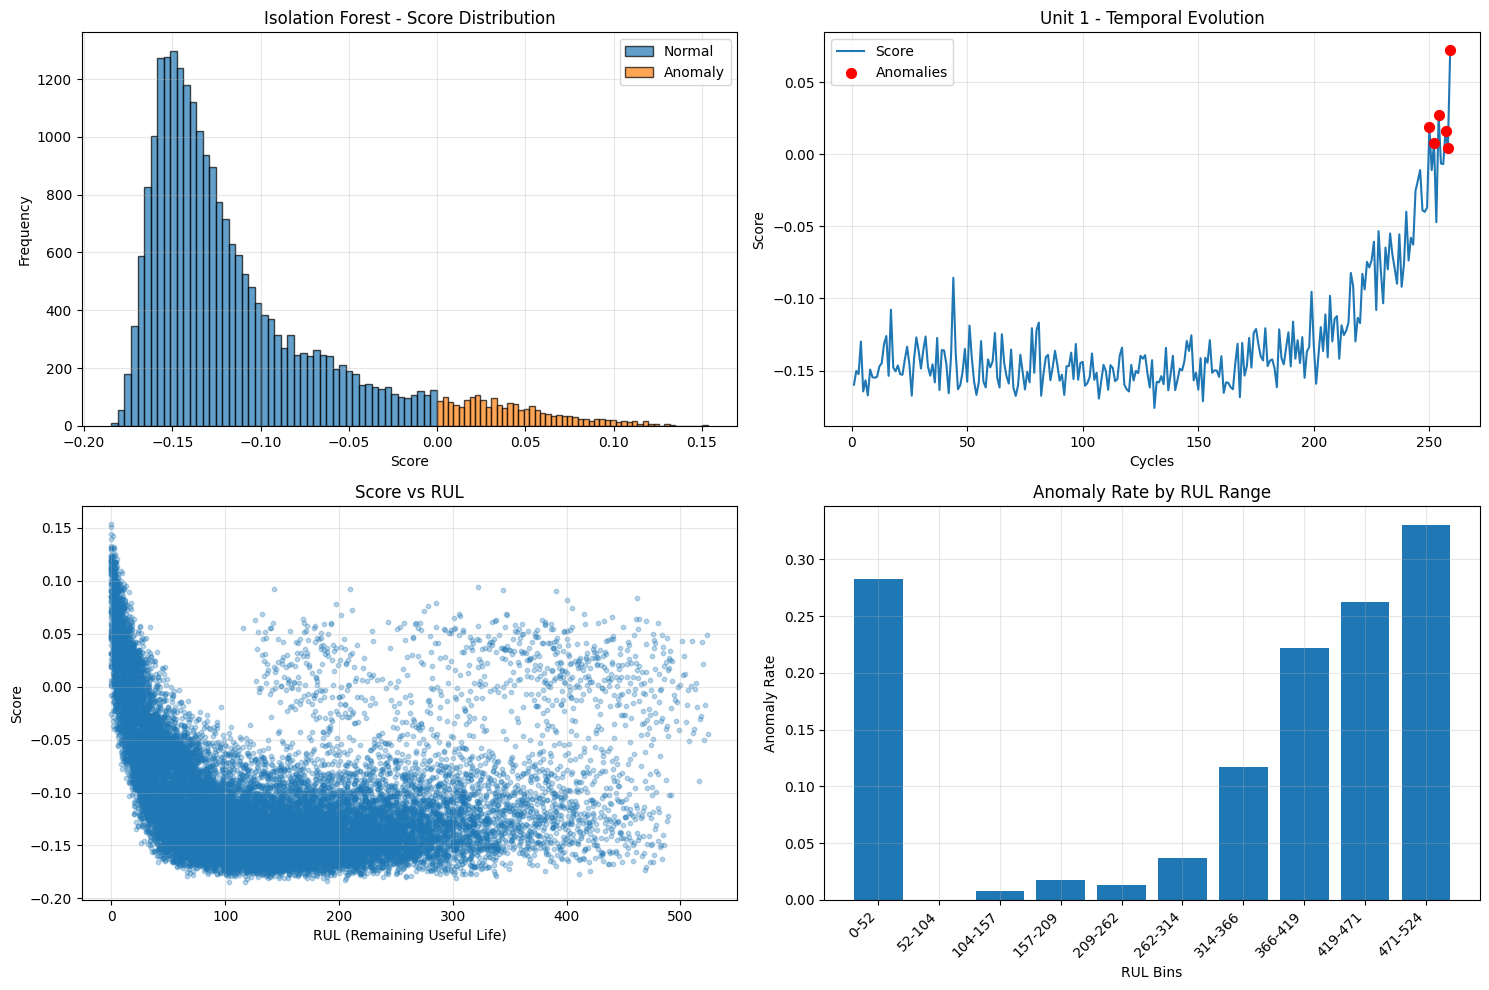

In [12]:
# 6. PLOTS
standard_plots(
    train=train,
    score_col='anomaly_score',
    method_name='Isolation Forest',
    output_path='./outputs'
)

In [13]:
# 7. SAVE
output_dir = Path('./outputs')
output_dir.mkdir(exist_ok=True)

train[['unit_id', 'time_cycles', 'RUL', 'anomaly_score', 'is_anomaly']].to_csv(
    output_dir / 'isolation_forest_anomalies.csv', index=False
)

pd.DataFrame([metrics]).to_csv(
    output_dir / 'isolation_forest_metrics.csv', index=False
)

print("✅ Saved to ./outputs/")

✅ Saved to ./outputs/


📊 Isolation Forest - FD001-TEST
Cobertura: 22.0% (22/100 unidades)
RUL promedio 1ª detección: 179.4 ciclos
Detección al 40.4% del ciclo
Detecciones tempranas (RUL>50): 13
Falsos positivos (RUL>150): 59.1%
% anomalías totales: 3.8%


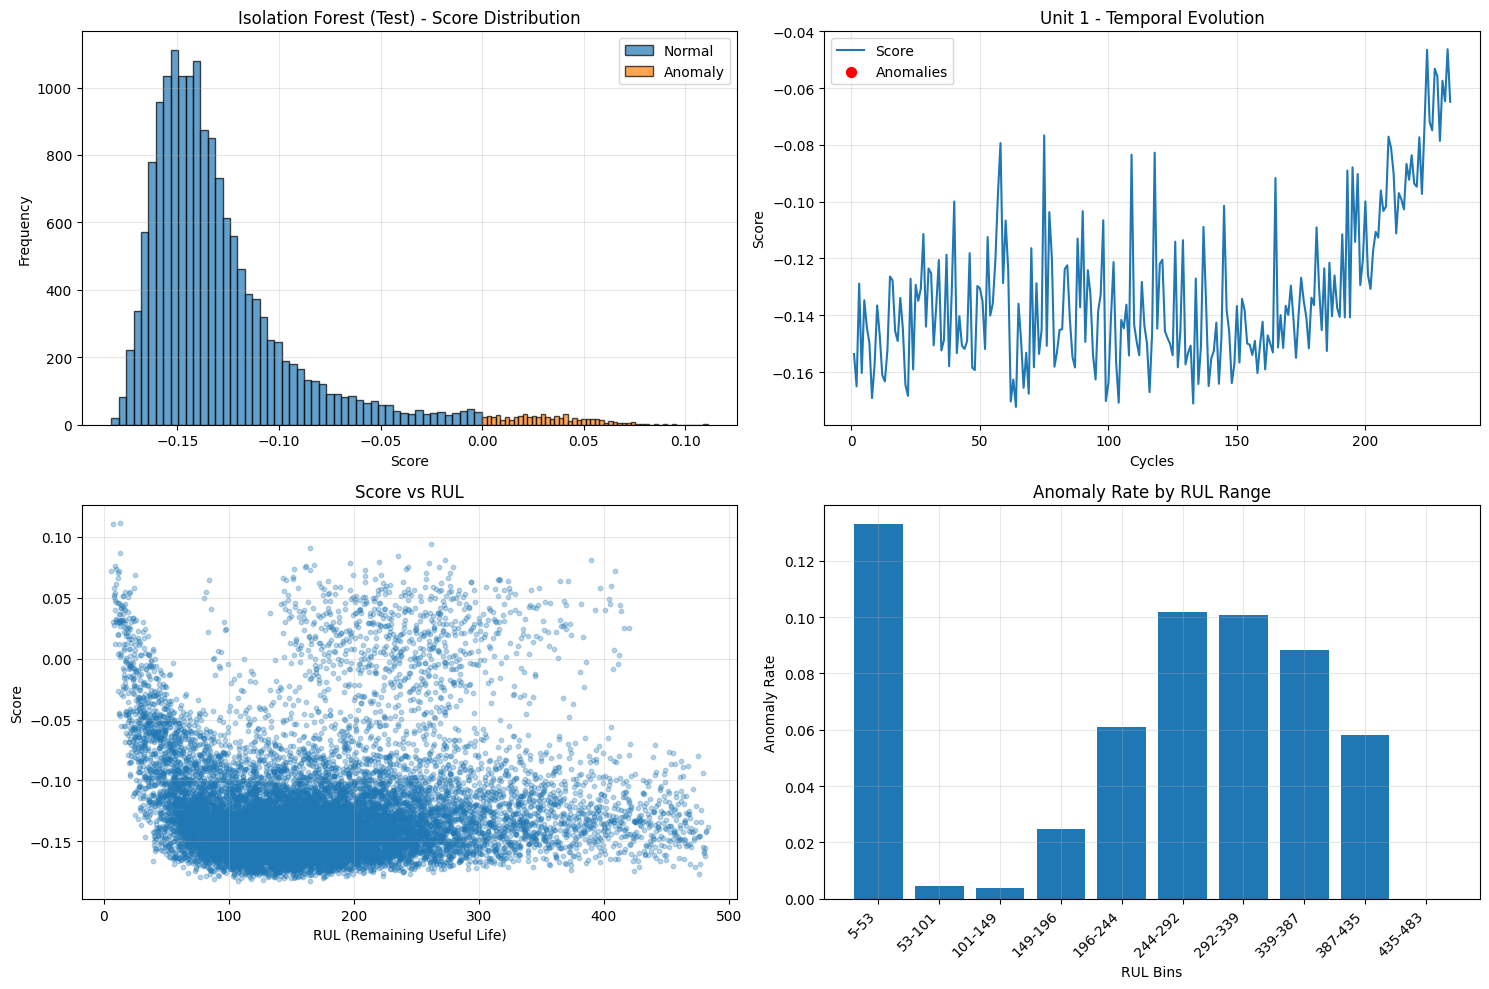

In [16]:
# TEST EVALUATION
test = pd.read_csv('../data/test.csv')
rul_test = pd.read_csv('../data/rul.csv')

# Predict
X_test = test[feature_cols].values
predictions_test = model.predict(X_test)
test['is_anomaly'] = (predictions_test == -1).astype(int)
test['anomaly_score'] = -model.decision_function(X_test)

# Calculate RUL
rul_test['unit_id'] = range(1, len(rul_test) + 1)
test = test.sort_values(['unit_id', 'time_cycles'])
test['max_cycle'] = test.groupby('unit_id')['time_cycles'].transform('max')
test = test.merge(rul_test, on='unit_id', how='left')  # Sin suffixes
test['RUL'] = test['RUL'] + (test['max_cycle'] - test['time_cycles'])

# Metrics & Plots
metrics_test = calculate_anomaly_metrics(test)
metrics_test['method'] = 'Isolation Forest'
metrics_test['dataset'] = 'FD001-TEST'
format_results(metrics_test)

standard_plots(test, 'anomaly_score', 'Isolation Forest (Test)', './outputs')

# Save
test[['unit_id', 'time_cycles', 'RUL', 'anomaly_score', 'is_anomaly']].to_csv(
    output_dir / 'isolation_forest_test_anomalies.csv', index=False
)
pd.DataFrame([metrics_test]).to_csv(
    output_dir / 'isolation_forest_test_metrics.csv', index=False
)

In [17]:
print(metrics_test)

{'method': 'Isolation Forest', 'dataset': 'FD001-TEST', 'total_units': 100, 'units_detected': 22, 'detection_rate': 22.0, 'avg_first_detection_rul': np.float64(179.36363636363637), 'avg_detection_cycle_pct': np.float64(40.39344936372624), 'early_detections': 13, 'false_positive_rate': 59.09090909090909, 'anomaly_percentage': np.float64(3.8201976379850566)}
